In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.inspection import permutation_importance

# Loading the dataset

In [76]:
filtered_df=pd.read_csv('DATASET/filtered_df.csv')
filtered_test=pd.read_csv('DATASET/filtered_test.csv')

In [77]:
filtered_df.drop(columns=['Unnamed: 0'],inplace=True)
filtered_test.drop(columns=['Unnamed: 0'],inplace=True)

In [78]:
X_train = filtered_df.drop(columns=['y']).copy()
y_train = filtered_df['y'].copy()

filtered_test.drop(columns=['y'],inplace=True)

In [79]:
X_train.columns = X_train.columns.str.replace(' ', '_')
filtered_test.columns = filtered_test.columns.str.replace(' ', '_')

# Loading the model

In [80]:
stack=joblib.load('models/FINAL_stacking_model.pkl')

In [81]:
print(stack)

StackingRegressor(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_po...
                                            n_estimators=4600, n_jobs=-1,
                                            num_parallel_tree=None

In [82]:
print(stack.estimators_)
print(stack.final_estimator_)

[XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0085, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=4600,
             n_jobs=-1, num_parallel_tree=None, ...), LGBMRegressor(colsample_bytree=0.8, learning_rate=0.008, min_child_samples=1,
              n_estimators=4600, n_jobs=-1, num_leaves=63,
              objective='regression', random_state=42, reg_lambda=0.01,
              subsample=0.8, verbose=-1)]
Elas

In [83]:
stack.fit(X_train, y_train)

StackingRegressor(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_po...
                                            n_estimators=4600, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                              ('lgb',
                               LGBMRegressor(colsample_bytree=0.8,
                                             learning_rate=0.008,
                                             min_child_samples=1,
                                             n_estimators=4600, n_jobs=-1,
                                             num_leaves=63,
                                             objective='regression',
                                             random_state=42, reg_lambda=0.01,
                                             subsample=0.8, verbose=-1))],
                  final_estimator=ElasticNetCV(alphas=[0.0004641588833612782],
                                               cv=10, l1_ratio=[0.01],
                                               random_state=42),
                  n_jobs=-1)

In [44]:
y_pred = stack.predict(filtered_test)
y_pred_test_normal = np.expm1(y_pred)

## Extracting Models

In [50]:
xgb_model = stack.named_estimators_['xgb']
lgb_model = stack.named_estimators_['lgb']

# Graphical Analysis

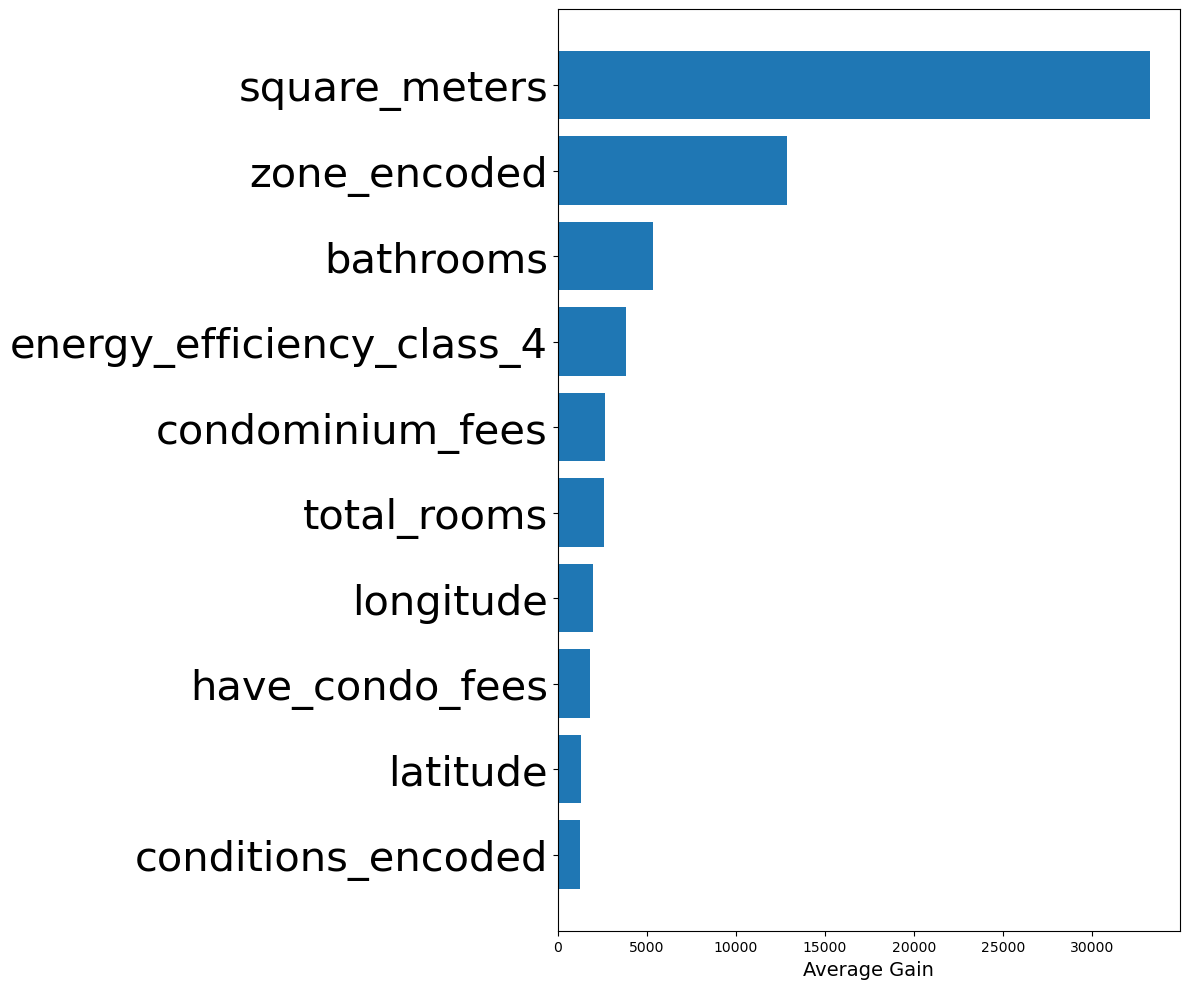

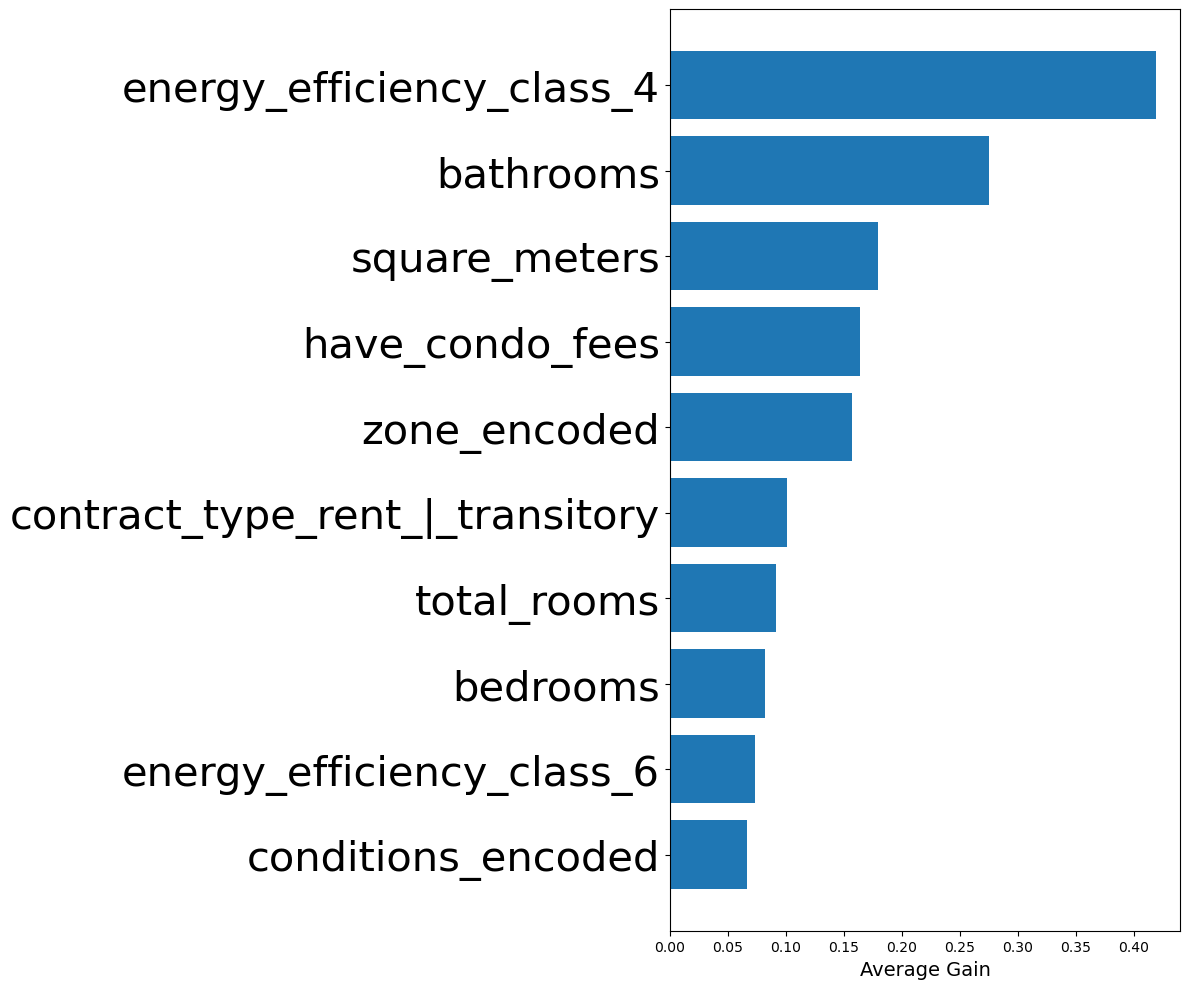

In [64]:
# ------------------------
# LIGHTGBM FEATURE IMPORTANCE
# ------------------------
booster = lgb_model.booster_  
importances = booster.feature_importance(importance_type='gain')
features = np.array(X_train.columns)
order = np.argsort(importances)[::-1][:10]

# Plot
plt.figure(figsize=(12, 10))
plt.barh(features[order][::-1], importances[order][::-1])
plt.xlabel("Average Gain", fontsize=14)  # Increase x-axis label font size
plt.yticks(fontsize=30)  # Increase y-axis tick label size
plt.tight_layout()
plt.savefig("IMAGES/lgb_top25_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# ------------------------
# XGBOOST FEATURE IMPORTANCE
# ------------------------
booster = xgb_model.get_booster()
importances = booster.get_score(importance_type='gain')

# Convert to sorted DataFrame
importance_df = pd.DataFrame({
    'feature': list(importances.keys()),
    'gain': list(importances.values())
})
importance_df = importance_df.sort_values(by='gain', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 10))
plt.barh(importance_df['feature'][::-1], importance_df['gain'][::-1])
plt.xlabel("Average Gain", fontsize=14)  # Increase x-axis label font size
plt.yticks(fontsize=30)  # Increase y-axis tick label size
plt.tight_layout()
plt.savefig("IMAGES/xgb_top25_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

In [69]:
# pip install shap

## Stack

In [47]:
# Fit stack on full data
stack.fit(X_train, y_train)

# meta_learner is an ElasticNet; get coefficients
coefs = stack.final_estimator_.coef_
intercept = stack.final_estimator_.intercept_

print(f"ElasticNet blend:   ŷ = {coefs[0]:.3f}·XGB  +  {coefs[1]:.3f}·LGB  +  {intercept:.3f}")

ElasticNet blend:   ŷ = 0.421·XGB  +  0.572·LGB  +  0.055


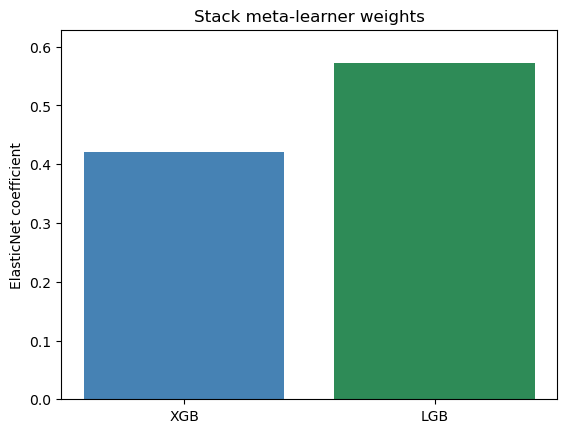

In [48]:
plt.bar(["XGB", "LGB"], coefs, color=["steelblue", "seagreen"])
plt.ylabel("ElasticNet coefficient")
plt.title("Stack meta-learner weights")
plt.ylim(0, max(coefs)*1.1)
plt.show()

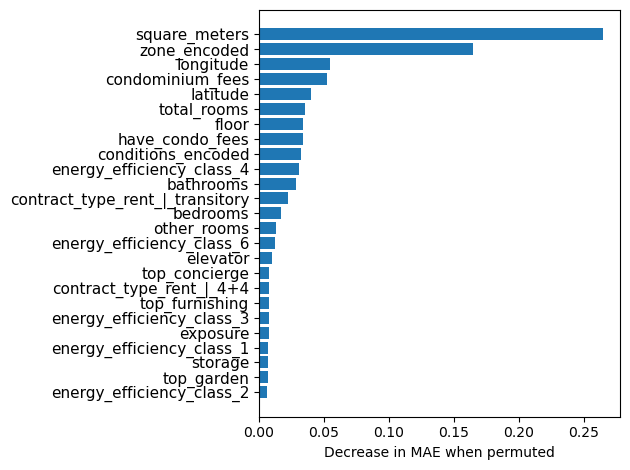

In [75]:
plt.barh(imp_df.feature[:25][::-1], imp_df.importance[:25][::-1])
plt.xlabel("Decrease in MAE when permuted")

# Increase the font size of y-axis labels
plt.yticks(fontsize=11)

# Remove the title by not setting it or explicitly setting to empty string
plt.title("")

plt.tight_layout()

# Save the figure
plt.savefig("IMAGES/permutation_importance.png", dpi=300)  # you can specify filename and dpi

plt.show()